In [1]:
# LO CIRCUITS
# can always get a unitary matrix from a LO circuit in Perceval
# we can convert a matrix into a ZW circuit in optyx
# the opposite way is how we evaluate LO circuits in perce|val

In [2]:
# MORE GENERAL CIRCUITS
#

In [3]:
import numpy as np

import perceval as pcvl
from perceval import catalog

In [4]:
import numpy as np

import perceval as pcvl
from perceval import catalog
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

p.add(2, ff_X)
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})
p.add(0, ff_Z)

In [5]:
import numpy as np

import perceval as pcvl
from perceval import catalog


# Creation of the qubit to transmit
alpha = np.random.random()
beta = np.random.random() * np.exp(2 * np.pi * 1j * np.random.random())
# alpha |0> + beta |1> in dual rail encoding
to_transmit = (0.7071067811865476+0j)*pcvl.BasicState([1, 0]) + (-0.21850801222441052+0.6724985119639574j)*pcvl.BasicState([0, 1]) 
to_transmit.normalize()

alpha = to_transmit[pcvl.BasicState([1, 0])]  # Normalized
beta = to_transmit[pcvl.BasicState([0, 1])]

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
#input_state = bell_state
p.min_detected_photons_filter(2)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the post-processed cnot manually
input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

res = p.probs()
print(res)

{'results': BSDistribution(<class 'float'>, {|1,0,1,0,1,0>: 0.12500000000000003, |0,1,1,0,1,0>: 0.12499999999999996, |0,1,1,0,0,1>: 0.12500000000000003, |1,0,0,1,1,0>: 0.125, |1,0,0,1,0,1>: 0.125, |1,0,1,0,0,1>: 0.12500000000000003, |0,1,0,1,1,0>: 0.12499999999999996, |0,1,0,1,0,1>: 0.12500000000000003}), 'global_perf': 0.11111111111111112}


In [6]:
bell_state

0.707*|0,1,0,1>+0.707*|1,0,1,0>

In [7]:
to_transmit

(-0.219+0.672I)*|0,1>+0.707*|1,0>

In [8]:
input_state

(-0.155+0.476I)*|0,1,0,1,0,1,0,0>+(-0.155+0.476I)*|0,1,1,0,1,0,0,0>+0.5*|1,0,0,1,0,1,0,0>+0.5*|1,0,1,0,1,0,0,0>

In [9]:
from optyx.utils.utils import matrix_to_zw, invert_perm
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram, Measure
from optyx.classical import Select
from optyx.photonic import Create
from optyx.utils.postselect_parser import compile_postselect
from optyx.core.zw import Endo
import numpy as np
import perceval as pcvl


# ---------- Small utilities ----------

def detector(component, wires):
    if component.type == DetectionType.PNR:
        return photonic.NumberResolvingMeasurement(len(wires))
    if component.type == DetectionType.Threshold:
        return photonic.PhotonThresholdMeasurement(len(wires))
    raise ValueError(f"Unsupported perceval detector type: {component.type}")


def _default_action(component):
    return matrix_to_zw(np.array(component.default_circuit.U, dtype=np.complex128))


def _state_predicate(state):
    """Return ClassicalFunction that outputs 1 iff input equals 'state'."""
    def f(x):
        return [1 if all(s == a for s, a in zip(state, x)) else 0]
    return ClassicalFunction(f, mode**len(state), bit)


def _rewire_and_context(*, component, wires, circuit, n_classical, n_action, n_offset,
                        perm_dom_neg, perm_dom_pos):
    """Compute (input_perm, output_perm, left, right) based on component._offset sign."""
    if component._offset < 0:
        # classical wires after action+offset
        p_input = (
            list(range(n_action + n_offset, n_action + n_offset + n_classical)) +
            list(range(0, n_action)) +
            list(range(n_action, n_action + n_offset))
        )
        input_perm = Diagram.permutation(p_input, perm_dom_neg)
        output_perm = Diagram.permutation(invert_perm(p_input), input_perm.cod)
        left  = circuit.cod[:min(wires) - n_offset - n_action]
        right = circuit.cod[max(wires) + 1:]
    else:
        # classical wires before offset+action
        p_input = (
            list(range(n_classical, n_classical + n_offset)) +
            list(range(0, n_classical)) +
            list(range(n_classical + n_offset, n_classical + n_offset + n_action))
        )
        input_perm = Diagram.permutation(p_input, perm_dom_pos)
        output_perm = Diagram.permutation(invert_perm(p_input), input_perm.cod)
        left  = circuit.cod[:min(wires)]
        right = circuit.cod[max(wires) + n_offset + n_action + 1:]
    return input_perm, output_perm, left, right


def _assemble_controlled_box(map_items, *, default_action):
    """
    Build the feed-forward controlled box from (state, action_box) pairs.
    action_box must already be a ZW diagram (matrix_to_zw applied).
    """
    box = None
    n_action = len(default_action.dom)
    for i, (state, action) in enumerate(map_items):
        if i == 0:
            box = mode**len(state) @ photonic.Id(n_action)

        # duplicate classical control and compute predicate
        copy = Spider(1, 2, mode)**len(state)
        permutation = Diagram.permutation(
            list(range(0, 2*len(state), 2)) + list(range(1, 2*len(state), 2)),
            mode**(2*len(state))
        )
        func = _state_predicate(list(state))

        ctrl_box = BitControlledGate(action, default_action)
        q_wires = qmode**n_action

        box >>= (
            copy @ q_wires >>
            permutation @ q_wires >>
            Diagram.id(mode**len(state)) @ func @ q_wires >>
            Diagram.id(mode**len(state)) @ ctrl_box
        )
    return box


def _feedforward_common(*, component, wires, circuit, map_iter, action_from_item,
                        use_provider_dom: bool):
    """
    Shared implementation for both FFCircuitProvider and FFConfigurator.
    - map_iter: iterator of (state, payload) where payload -> action_box via action_from_item
    - action_from_item(item) must return a ZW action diagram
    - use_provider_dom switches between the two different permutation 'dom' conventions
    """
    default_action = _default_action(component)

    # numbers and offset
    n_classical = len(next(iter(map_iter.keys())))
    n_action = len(default_action.dom)
    n_offset = abs(component._offset)

    # build permutation domains for input permutation
    if use_provider_dom:
        perm_dom_neg = qmode**(n_action + n_offset) @ mode**n_classical
        perm_dom_pos = mode**n_classical @ qmode**(n_action + n_offset)
    else:
        # configurator: the dom is a slice of the current circuit wires
        perm_dom_neg = circuit.cod[min(wires) - n_offset - n_action : max(wires) + 1]
        perm_dom_pos = circuit.cod[min(wires) : max(wires) + n_offset + n_action + 1]

    input_perm, output_perm, left, right = _rewire_and_context(
        component=component, wires=wires, circuit=circuit,
        n_classical=n_classical, n_action=n_action, n_offset=n_offset,
        perm_dom_neg=perm_dom_neg, perm_dom_pos=perm_dom_pos
    )

    # prepare (state, action_box) pairs
    action_pairs = []
    for state, payload in map_iter.items():
        action_pairs.append((state, action_from_item(payload)))

    box = _assemble_controlled_box(action_pairs, default_action=default_action)

    # figure out the "offset wires" identity block to thread through
    if component._offset < 0:
        offset_wires = circuit.cod[
            len(left) + n_action : len(left) + n_action + n_offset
        ]
    else:
        offset_wires = circuit.cod[
            len(left) + n_classical : len(left) + n_classical + n_offset
        ]

    return (input_perm >> offset_wires @ box >> output_perm), left, right


# ---------- Feed-forward adapters ----------

def ff_circuit_provider(component, wires, circuit):
    def action_from_item(action_circuit):
        return matrix_to_zw(np.array(action_circuit.U, dtype=np.complex128))

    box, left, right = _feedforward_common(
        component=component,
        wires=wires,
        circuit=circuit,
        map_iter=component._map,
        action_from_item=action_from_item,
        use_provider_dom=True,
    )
    return box, left, right


def ff_configurator(component, wires, circuit):
    free_symbols = component._controlled.U.free_symbols

    def action_from_item(symbol_values):
        # substitute symbol values and convert to ZW
        subs_map = {s: v for s, v in zip(free_symbols, symbol_values.values())}
        action_U = np.array(component._controlled.U.subs(subs_map).evalf(), dtype=np.complex128)
        return matrix_to_zw(action_U)

    box, left, right = _feedforward_common(
        component=component,
        wires=wires,
        circuit=circuit,
        map_iter=component._configs,
        action_from_item=action_from_item,
        use_provider_dom=False,
    )
    return box, left, right


# ---------- Other components (unchanged behavior) ----------

def unitary(component, wires):
    if component.U.is_symbolic and not isinstance(component.U, pcvl.MatrixN):
        if len(component.U.free_symbols) != 0:
            raise TypeError("Symbolic circuits are not currently supported")
    U = np.array(component.U, dtype=np.complex128)
    if U.shape[0] != len(wires):
        raise ValueError("A component acting on polarisation modes.")
    return Channel(name=component.name, kraus=matrix_to_zw(U))


def heralds_diagram(heralds, n_modes, circuit, in_out):
    layer = photonic.Id(0)
    create_select = Create if in_out == "in" else Select if in_out == "out" else None
    if create_select is None:
        raise ValueError("in_out must be either 'in' or 'out'")

    if heralds is not None:
        for m in range(n_modes):
            if m in heralds:
                layer @= create_select(heralds[m])
            else:
                layer @= circuit.cod[m] if in_out == "out" else photonic.Id(1)
    return layer


def postselection(circuit, p):
    measure = Measure(circuit.cod)
    n_post = len(circuit.cod)

    copy = Spider(1, 2, mode)**n_post
    permutation = Diagram.permutation(
        list(range(0, 2*n_post, 2)) + list(range(1, 2*n_post, 2)),
        mode**(2*n_post)
    )
    measure >>= copy >> permutation
    postselect_f = ClassicalFunction(compile_postselect(str(p.post_select_fn)), mode**n_post, bit)
    measure >>= postselect_f @ mode**n_post

    postselection = BitControlledGate(
        Diagram.id(mode**n_post),
        Channel("PostSelection", Endo(0)**n_post, mode**n_post, mode**n_post),
        classical=True
    )
    measure >>= postselection

    return measure


def from_perceval(p):
    n_modes = p.circuit_size
    circuit = photonic.Id(n_modes)
    heralds = p.heralds

    circuit = heralds_diagram(heralds, n_modes, circuit, "in") >> circuit

    for wires, component in p.components:
        left = circuit.cod[:min(wires)]
        right = circuit.cod[max(wires) + 1:]

        if isinstance(component, pcvl.Detector):
            box = detector(component, wires)
        elif isinstance(component, pcvl.components.feed_forward_configurator.FFCircuitProvider):
            box, left, right = ff_circuit_provider(component, wires, circuit)
        elif isinstance(component, pcvl.components.feed_forward_configurator.FFConfigurator):
            box, left, right = ff_configurator(component, wires, circuit)
        elif isinstance(component, pcvl.components.Barrier):
            continue
        elif hasattr(component, "U"):
            box = unitary(component, wires)
        else:
            raise ValueError(f"Unsupported perceval component type: {type(component)}")

        circuit >>= (left @ box @ right)

    circuit >>= heralds_diagram(heralds, n_modes, circuit, "out")
    if p.post_select_fn is not None:
        circuit >>= postselection(circuit, p)

    return circuit


In [10]:
from optyx.qubits import Z, Scalar, Ket
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)

In [11]:
transmit = Ket("+") >> Z(1, 1, 0.3)

In [12]:
transmit.eval().amplitudes()

{(0,): (0.7071067811865476+0j),
 (1,): (-0.21850801222441052+0.6724985119639574j)}

In [13]:
inp = transmit @ bell_state

In [14]:
from optyx import Channel

dist = (
    transmit @ bell_state >>
    DualRail(3) >>
    Channel.from_perceval(p)
).eval().prob_dist()

In [16]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    # Check keys in d1 but not in d2
    for key in d1.keys() - d2.keys():
        print(f"Key {key} is in d1 but not in d2.")
    # Check keys in d2 but not in d1
    for key in d2.keys() - d1.keys():
        print(f"Key {key} is in d2 but not in d1.")
    # Check matching keys for value closeness
    for key in d1.keys() & d2.keys():
        if not np.isclose(d1[key], d2[key], rtol=rtol, atol=atol):
            print(f"Values for key {key} differ: {d1[key]} vs {d2[key]}")
            
check_dict_agreement(
    {tuple(k): v for k, v in dict(res["results"]).items()},
    dist
)


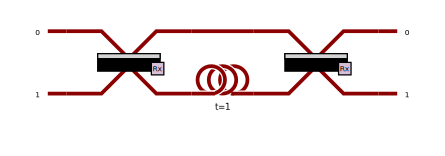

In [17]:
HOM = pcvl.Processor("SLOS", 2)

HOM.add(0, pcvl.BS())
HOM.add(1, pcvl.TD(1))
HOM.add(0, pcvl.BS())

pcvl.pdisplay(HOM)

In [18]:
Channel.from_perceval(HOM)

ValueError: Unsupported perceval component type: <class 'perceval.components.non_unitary_components.TD'>

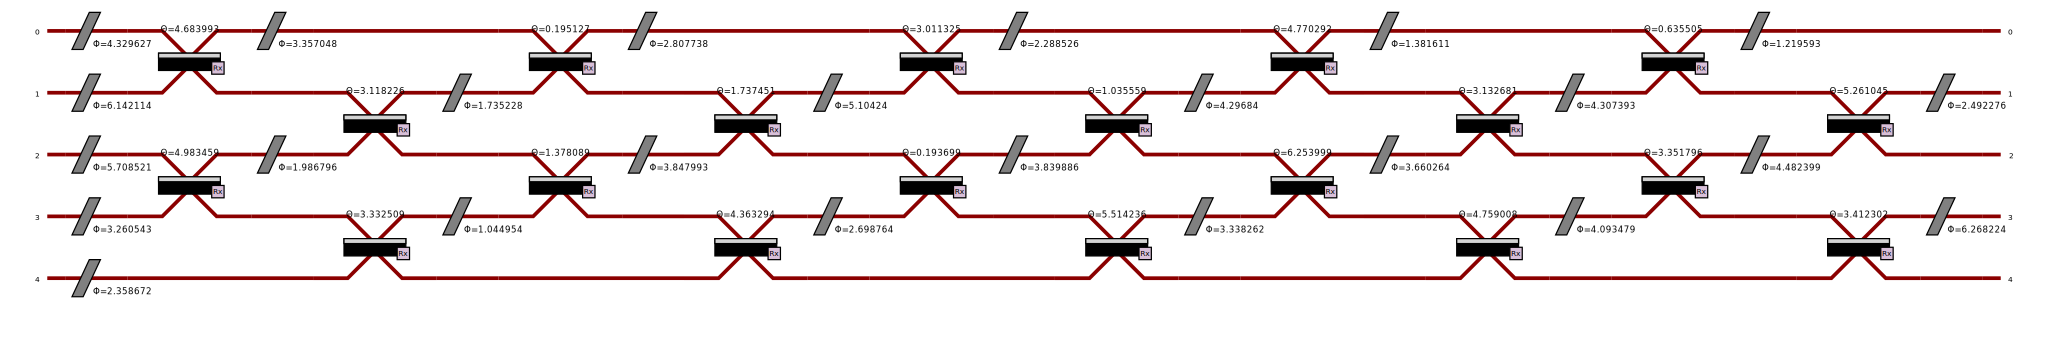

In [19]:
import datetime
import math
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
from tqdm.notebook import tqdm_notebook

import perceval as pcvl

N=5
n_try=10
n_iter=3
n_process=8
angle_min=-15
angle_max=30
angle_step=2
n_unitary=300
logfilebs='bsbasednotebook-opt'
logfilemzi='mzibasednotebook-opt'

bs = pcvl.GenericInterferometer(N,
                                lambda idx: pcvl.BS(theta=np.pi * 2 * random.random()) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * N,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)

In [20]:
#from_perceval(p_new).eval()

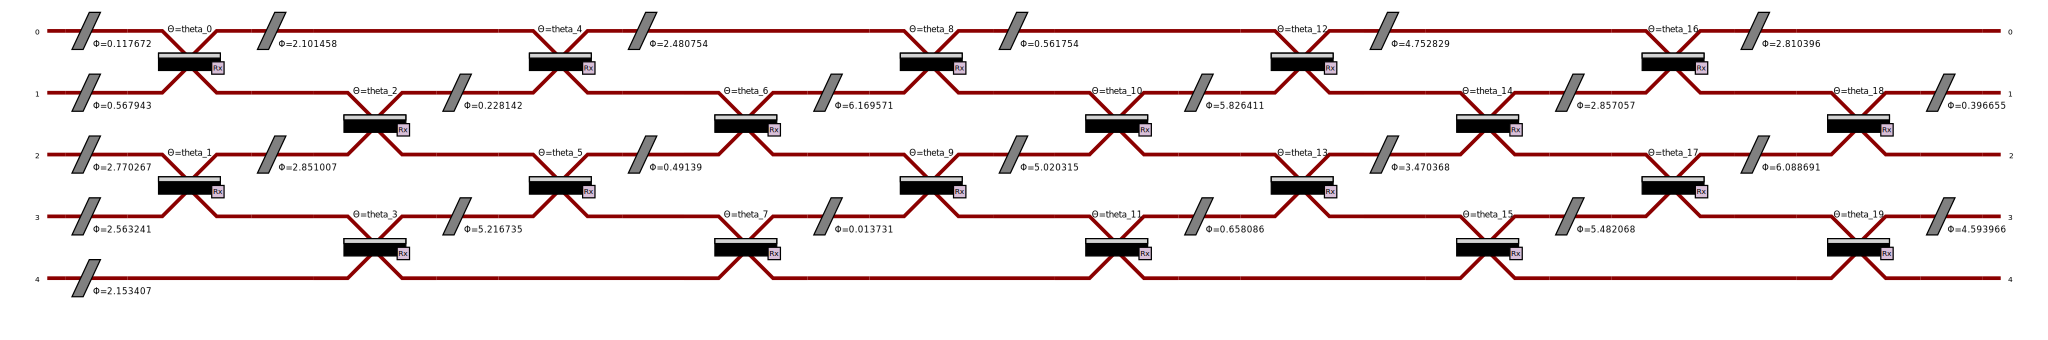

In [21]:
bs = pcvl.GenericInterferometer(N,
                                lambda idx: pcvl.BS(theta=pcvl.P("theta_%d" % idx)) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * N,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)

In [22]:
bs.params

dict_keys(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19'])

In [23]:
isinstance(p, pcvl.Circuit)

False

In [24]:
bs.m

5

In [25]:
p = pcvl.Processor("SLOS", 5)
p.add(0, bs)

p_new = pcvl.Processor("SLOS", 5)
for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [26]:
Channel.from_perceval(bs)

TypeError: Symbolic circuits are not currently supported

Optical circuit for Shor's algorithm


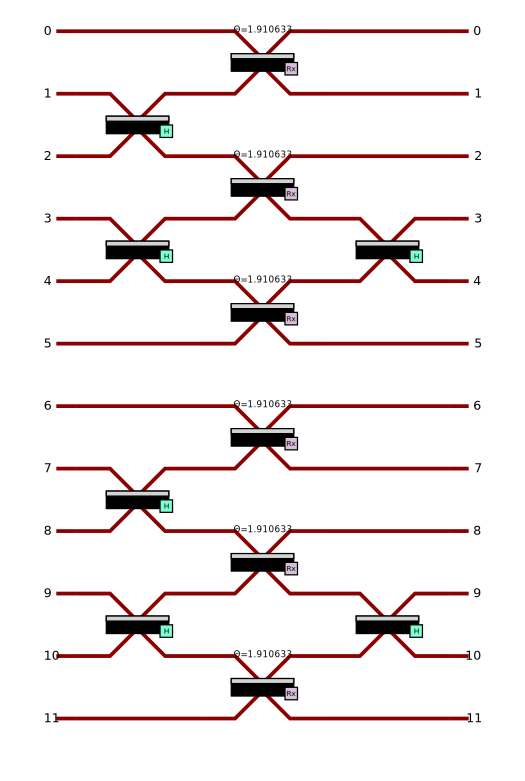

In [27]:
import perceval as pcvl
def toFockState(qubitState):
    # path encoding
    pe = {0:[1,0],  1:[0,1]}
    return [0] + pe[qubitState[0]] + pe[qubitState[2]] + [0, 0] + pe[qubitState[1]] + pe[qubitState[3]] + [0]
def toQubitState(fockState):
    # qubit modes
    x1 = [1, 2]
    f1 = [3, 4]
    x2 = [7, 8]
    f2 = [9, 10]
    # auxiliary modes
    am1 = [0, 5]
    am2 = [6, 11]

    # auxiliary modes
    for i in am1 + am2:
        if fockState[i]!=0:
            return None
    L=[]
    # qubit modes
    for q in [x1, x2, f1, f2]:
        if fockState[q[0]]+fockState[q[1]] != 1:
            return None
        else:
            L.append(fockState[q[1]])
    return L
def strState(state):
    return str(pcvl.BasicState(state))
circ = pcvl.Circuit(12)

# qubit modes
# for qubit states 0, 1
x1 = [1, 2]
f1 = [3, 4]
x2 = [7, 8]
f2 = [9, 10]
# auxiliary modes
am1 = [0, 5]
am2 = [6, 11]


# H gates
for q in [x1, f1, x2, f2]:
    circ.add(q, pcvl.BS.H())

# CZ gates
for x, f, am in [(x1, f1, am1), (x2, f2, am2)]:
    circ.add((am[0], x[0]), pcvl.BS(pcvl.BS.r_to_theta(1/3))) # R = 1/3
    circ.add((x[1],  f[0]), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
    circ.add((f[1], am[1]), pcvl.BS(pcvl.BS.r_to_theta(1/3)))

# H gates
for q in [f1, f2]:
    circ.add(q, pcvl.BS.H())

print("Optical circuit for Shor's algorithm")
pcvl.pdisplay(circ)

In [28]:
qubit_istate = [0,0,0,1]
istate = toFockState(qubit_istate)

print("Input qubit state:", strState(qubit_istate))
print("Corresponding input Fock state:", strState(istate))
backend = pcvl.BackendFactory().get_backend("Naive")
backend.set_circuit(circ)
backend.set_input_state(pcvl.BasicState(istate))

Input qubit state: |0,0,0,1>
Corresponding input Fock state: |0,1,0,1,0,0,0,1,0,0,1,0>


In [29]:
input_states = {
    pcvl.BasicState(pcvl.BasicState(istate)): strState(qubit_istate)
}

expected_output_states = {
    pcvl.BasicState(toFockState([x1,x2,x1,1-x2])): strState([x1,x2,x1,1-x2])
    for x1 in [0,1] for x2 in [0,1]
}

p = pcvl.Processor("Naive", circ)

ca = pcvl.algorithm.Analyzer(p, input_states, expected_output_states)
ca.compute()

print("Output state distribution: (post-selected on expected qubit states, not renormalized)")
print("|x1,x2,f1,f2>")
pcvl.pdisplay(ca)

Output state distribution: (post-selected on expected qubit states, not renormalized)
|x1,x2,f1,f2>


,"|0,0,0,1>","|0,1,0,0>","|1,0,1,1>","|1,1,1,0>"
"|0,0,0,1>",0.003086,0.003086,0.003086,0.003086


In [30]:
input_states

{|0,1,0,1,0,0,0,1,0,0,1,0>: '|0,0,0,1>'}

In [31]:
expected_output_states

{|0,1,0,1,0,0,0,1,0,0,1,0>: '|0,0,0,1>',
 |0,1,0,1,0,0,0,0,1,1,0,0>: '|0,1,0,0>',
 |0,0,1,0,1,0,0,1,0,0,1,0>: '|1,0,1,1>',
 |0,0,1,0,1,0,0,0,1,1,0,0>: '|1,1,1,0>'}

In [32]:
p = pcvl.Processor("Naive", 12)
p.add(0, circ)

In [33]:
p_new = pcvl.Processor("Naive", 12)
for c in p.flatten():
    p_new.add(min(c[0]), c[1])

In [34]:
optyx_circ = from_perceval(p_new)

In [35]:
state_ = [0,1,0,1,0,0,0,1,0,0,1,0]
state_optyx = photonic.Create(*state_)

In [36]:
from optyx.classical import PostselectDigit

In [37]:
# from cotengra import ReusableHyperCompressedOptimizer
# from optyx.core.backends import QuimbBackend
# opt = ReusableHyperCompressedOptimizer(max_repeats=32)
# backend = QuimbBackend(hyperoptimiser=opt, contraction_params={"chi":2})

# (
#     state_optyx >>
#     optyx_circ >>
#     Select(*[0,1,0,1,0,0,0,1,0,0,1,0])
# ).eval(backend=backend)

In [38]:
(
    state_optyx >>
    optyx_circ >>
    Select(*[0,1,0,1,0,0,0,1,0,0,1,0])
).is_pure

True

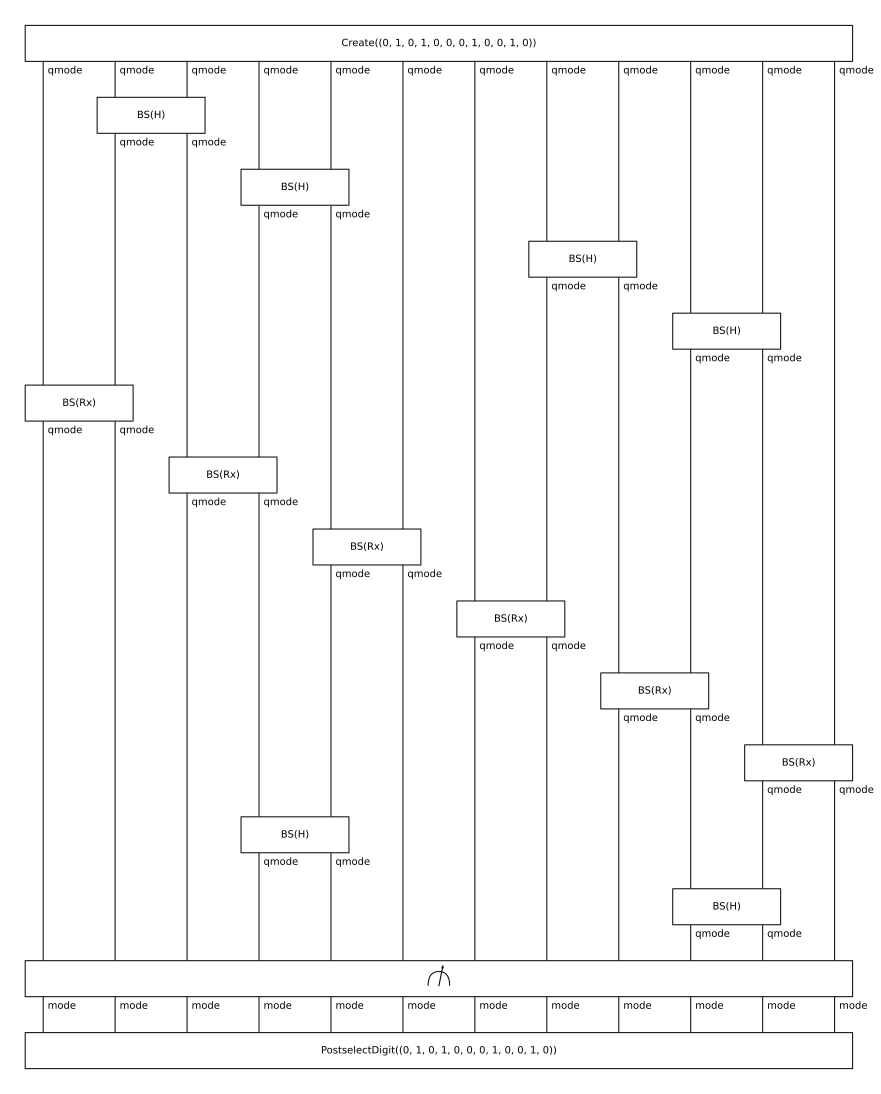

In [39]:
(
    state_optyx >>
    optyx_circ >>
    photonic.NumberResolvingMeasurement(12) >>
    PostselectDigit(*[0,1,0,1,0,0,0,1,0,0,1,0]) 
).draw()

In [40]:
import math

from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

import perceval as pcvl

Grover optical circuit for searching database element "00":


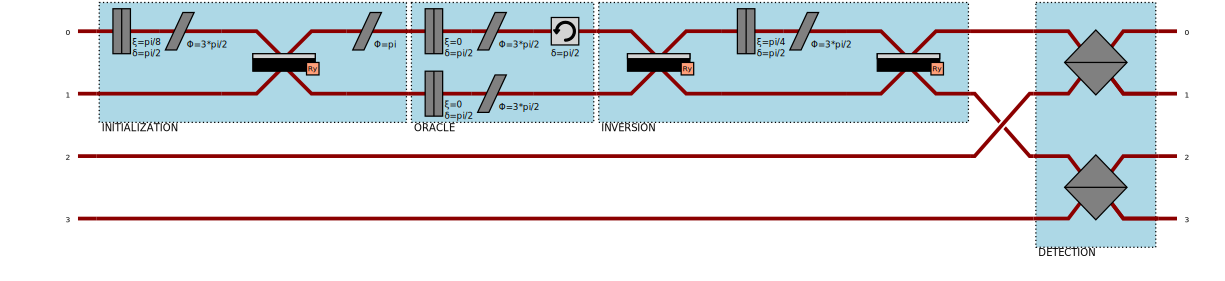

In [41]:
states = [pcvl.BasicState("|0,{P:H}>"),
          pcvl.BasicState("|0,{P:V}>"),
          pcvl.BasicState("|{P:H},0>"),
          pcvl.BasicState("|{P:V},0>"),
         ]

states_modes = [
    pcvl.BasicState([0, 0, 0, 1]),
    pcvl.BasicState([0, 0, 1, 0]),
    pcvl.BasicState([0, 1, 0, 0]),
    pcvl.BasicState([1, 0, 0, 0])
]
BS = pcvl.BS.Ry()
def HWP(xsi):
    hwp = pcvl.Circuit(m=1)
    hwp.add(0, pcvl.HWP(xsi)).add(0, pcvl.PS(-math.pi/2))
    return hwp

pcvl.pdisplay(HWP(math.pi/2))
init_circuit = (pcvl.Circuit(m=2, name="Initialization")
                // HWP(math.pi / 8)
                // BS
                // pcvl.PS(-math.pi))

pcvl.pdisplay(init_circuit)

def oracle(mark):
    """Values 0, 1, 2 and 3 for parameter 'mark' respectively mark the elements "00", "01", "10" and "11" of the list."""
    oracle_circuit = pcvl.Circuit(m=2, name='Oracle')
    # The following dictionary translates n into the corresponding component settings
    oracle_dict = {0: (1, 0), 1: (0, 1), 2: (1, 1), 3: (0, 0)}
    PC_state, LC_state = oracle_dict[mark]
    # Mode b
    if PC_state == 1:
        oracle_circuit //= HWP(0)
    oracle_circuit.add(0, pcvl.PR(math.pi/2))
    if LC_state == 1:
        oracle_circuit //= HWP(0)
    # Mode a
    if LC_state == 1:
        oracle_circuit //= (1, HWP(0))
    if PC_state == 1:
        oracle_circuit //= (1, HWP(0))
    return oracle_circuit

pcvl.pdisplay(oracle(0))

inversion_circuit = (pcvl.Circuit(m=2, name='Inversion')
                     // BS
                     // HWP(math.pi / 4)
                     // BS)

pcvl.pdisplay(inversion_circuit)

detection_circuit = pcvl.Circuit(m=4, name='Detection')
detection_circuit.add((0, 1), pcvl.PBS())
detection_circuit.add((2, 3), pcvl.PBS())

def grover_circuit(mark):
    grover_circuit = pcvl.Circuit(m=4, name='Grover')
    grover_circuit.add(0, init_circuit).add(0, oracle(mark)).add(0, inversion_circuit)
    grover_circuit.add(1, pcvl.PERM([1, 0])).add(0, detection_circuit)
    return grover_circuit

print('Grover optical circuit for searching database element "00":')
pcvl.pdisplay(grover_circuit(0), recursive=True)


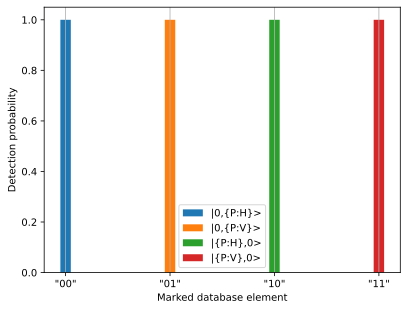

In [42]:
# Circuit simulation
input_state = pcvl.BasicState("|{P:H},0, 0, 0>")
results_list = []  # probability amplitudes storage

for mark in range(4):
    sim = pcvl.Processor("SLOS", grover_circuit(mark))
    ca = pcvl.algorithm.Analyzer(sim,
                              input_states=[input_state],
                              output_states=states_modes,
                             )
    results_list.append(ca.distribution[0])

# Plot data
labels = ['"00"', '"01"', '"10"', '"11"']
x = np.arange(4)  # label locations

fig, ax = plt.subplots(dpi=150)
for i in range(4):
    ax.bar(x, results_list[i].real, 0.1, label=str(states[i]))

ax.set_xlabel('Marked database element')
ax.set_ylabel('Detection probability')
ax.set_xticks(x, labels)
ax.legend()
ax.grid(True, axis='x')
plt.show()


In [43]:
p = pcvl.Processor("SLOS", 4)
p.add(0, grover_circuit(0))
p_new = pcvl.Processor("SLOS", 4)

for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [44]:
p.flatten()[0][1].U

Matrix([
[0.707106781186548*I,  0.707106781186547*I],
[0.707106781186547*I, -0.707106781186548*I]])

In [45]:
p.flatten()

[([0], <perceval.components.unitary_components.HWP at 0x73286da74380>),
 ([0], <perceval.components.unitary_components.PS at 0x73286de85760>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x73286df1bc50>),
 ([0], <perceval.components.unitary_components.PS at 0x73286da75a90>),
 ([0], <perceval.components.unitary_components.HWP at 0x73286de5bbc0>),
 ([0], <perceval.components.unitary_components.PS at 0x73286de598b0>),
 ([0], <perceval.components.unitary_components.PR at 0x73286de588f0>),
 ([1], <perceval.components.unitary_components.HWP at 0x73286e0056a0>),
 ([1], <perceval.components.unitary_components.PS at 0x73286de5b500>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x73286df1bc50>),
 ([0], <perceval.components.unitary_components.HWP at 0x73286dae10a0>),
 ([0], <perceval.components.unitary_components.PS at 0x73286df183b0>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x73286df1bc50>),
 ([1, 2], <perceval.components.unitary_components.PERM at 0x7328

In [46]:
Channel.from_perceval(grover_circuit(0))

ValueError: A component acting on polarisation modes.

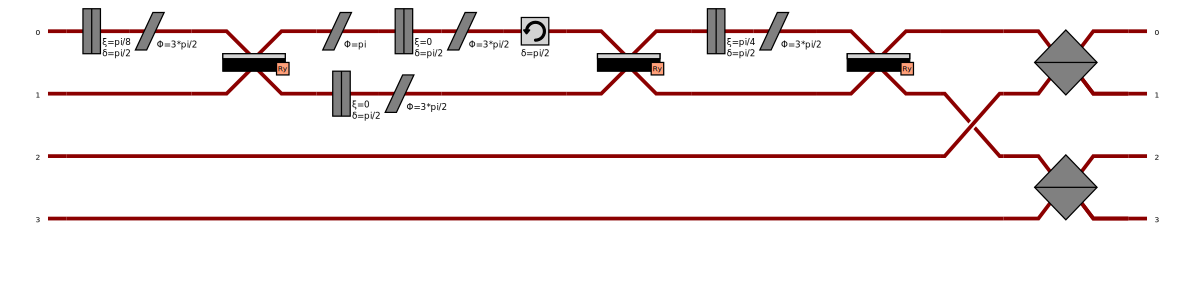

In [47]:
pcvl.pdisplay(p_new, recursive=True)

In [48]:
import math

import perceval as pcvl

p = pcvl.catalog['postprocessed cnot'].build_processor()

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"})
pcvl.pdisplay(ca)
print(f"performance = {pcvl.simple_float(ca.performance)[1]}, fidelity = {ca.fidelity*100}%")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 1/9, fidelity = 100.0%


In [49]:
p_optyx = Channel.from_perceval(p)

In [50]:
states = [
    photonic.Create(1, 0, 1, 0),
    photonic.Create(1, 0, 0, 1),
    photonic.Create(0, 1, 1, 0),
    photonic.Create(0, 1, 0, 1)
]

results = []
for i_state in states:
    circ = i_state >> p_optyx
    prob_dist = circ.eval().prob_dist()
    results.append(prob_dist)

In [51]:
results

[{(1, 0, 1, 0): (1+0j)},
 {(1, 0, 0, 1): (1+0j)},
 {(0, 1, 0, 1): (1+0j)},
 {(0, 1, 1, 0): (1+0j)}]

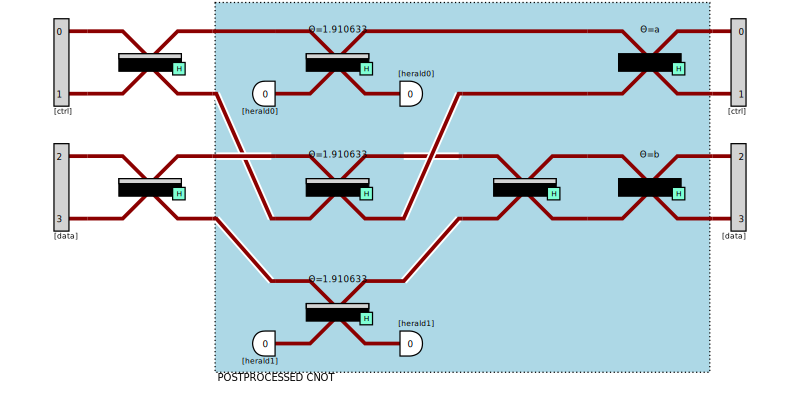

In [52]:
QPU = pcvl.Processor("SLOS", 4)
QPU.add(0, pcvl.BS.H())
QPU.add(0, p)

a = pcvl.Parameter("a")
b = pcvl.Parameter("b")

QPU.add(0, pcvl.BS.H(theta=a))
QPU.add(2, pcvl.BS.H(theta=b))

pcvl.pdisplay(QPU, recursive=True)

In [53]:
a.set_value(0)
b.set_value(0)
QPU.min_detected_photons_filter(2)
QPU.with_input(pcvl.BasicState([1, 0, 1, 0]))
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

state,probability
"|1,0,1,0,0,0>",1


In [54]:
output_distribution=QPU.probs()["results"]
pcvl.pdisplay(output_distribution, max_v=10)

state,probability
"|1,0,1,0>",1/2
"|0,1,0,1>",1/2


In [55]:
QPU_optyx = Channel.from_perceval(QPU)

In [56]:
(photonic.Create(1, 0, 1, 0) >> QPU_optyx).eval().prob_dist()

{(0, 1, 0, 1): (0.5000000000000001+0j), (1, 0, 1, 0): (0.5+0j)}

In [57]:
# imports
import matplotlib.pyplot as plt

import numpy as np

import perceval as pcvl
from perceval.components.unitary_components import BS
from perceval.backends import SLOSBackend
from perceval.simulators import Simulator
from perceval.components import Source

## Use the symbolic skin for display
from perceval.rendering import DisplayConfig, SymbSkin
DisplayConfig.select_skin(SymbSkin)

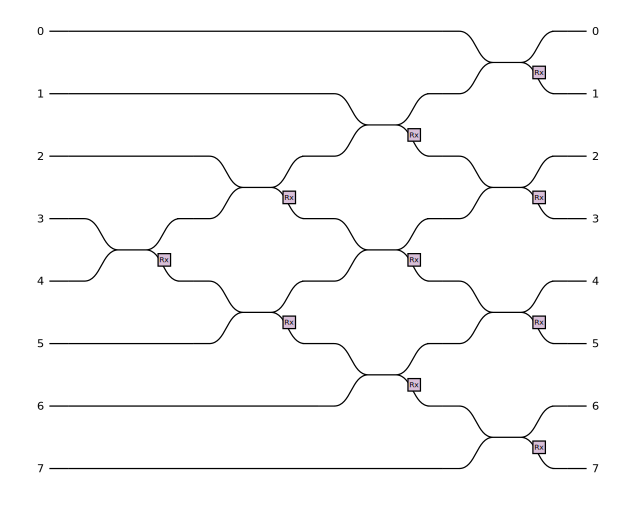

In [58]:
# number of steps
steps = 4
# spatial modes are twice the number of steps
n = 2*steps

# BS_array contains the input modes of the BSs at each step
BS_array = [[[0]*2]*(i+1) for i in range(steps)]

i_0 = n/2
for s in range(steps):
    if s==0:
        BS_array[s][0] = [i_0, i_0-1]
    else:
        z = 0
        for i, j in BS_array[s-1]:
            if [i+1, i] not in BS_array[s]:
                BS_array[s][z] = [i+1, i]
                z += 1
            if [j, j-1] not in BS_array[s]:
                BS_array[s][z] = [j, j-1]
                z += 1

# build the circuit
circuit = pcvl.Circuit(n)
for s in range(steps):
    for bs in BS_array[s]:
        circuit.add(int(bs[1]), BS())

# display the circuit
pcvl.pdisplay(circuit)

In [59]:
# define input state by inserting a photon in the first mode
mode = 3
in_list = [0]*n
in_list[mode] = 1
in_state = pcvl.BasicState(in_list)

# select a backend and define the simulator on the circuit
simulator = Simulator(SLOSBackend())
simulator.set_circuit(circuit)

#Define a source and input distribution due to source noise
source = Source(losses=0, indistinguishability=1)
input_distribution = source.generate_distribution(expected_input=in_state)

prob_dist = simulator.probs_svd(input_distribution)
print("output distribution:", prob_dist["results"])

output distribution: {
  |1,0,0,0,0,0,0,0>: 0.06249999999999997
  |0,1,0,0,0,0,0,0>: 0.0625
  |0,0,1,0,0,0,0,0>: 0.06250000000000006
  |0,0,0,1,0,0,0,0>: 0.06249999999999996
  |0,0,0,0,1,0,0,0>: 0.06250000000000008
  |0,0,0,0,0,1,0,0>: 0.5625
  |0,0,0,0,0,0,1,0>: 0.06249999999999997
  |0,0,0,0,0,0,0,1>: 0.06249999999999996
}


In [60]:
p = pcvl.Processor("SLOS", n)

p.add(0, circuit)

p_new = pcvl.Processor("SLOS", n)

for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [61]:
p_optyx = Channel.from_perceval(circuit)

(
    photonic.Create(*in_list) >>
    p_optyx
).eval().prob_dist()

{(0, 0, 0, 0, 0, 0, 0, 1): 0.0625,
 (0, 0, 0, 0, 0, 0, 1, 0): 0.0625,
 (0, 0, 0, 0, 0, 1, 0, 0): 0.5625,
 (0, 0, 0, 0, 1, 0, 0, 0): 0.0625,
 (0, 0, 0, 1, 0, 0, 0, 0): 0.0625,
 (0, 0, 1, 0, 0, 0, 0, 0): 0.0625,
 (0, 1, 0, 0, 0, 0, 0, 0): 0.0625,
 (1, 0, 0, 0, 0, 0, 0, 0): 0.0625}

In [62]:
# two photons input state
in_list = [0]*n
in_list[3], in_list[4] = 1, 1
in_state = pcvl.BasicState(in_list)

# select a backend and define the simulator on the circuit
simulator = Simulator(SLOSBackend())
simulator.set_circuit(circuit)

# define a source and input distribution due to source noise
source = Source(losses=0, indistinguishability=1)
input_distribution = source.generate_distribution(expected_input=in_state)

prob_dist = simulator.probs_svd(input_distribution)
print("output distribution:", prob_dist["results"])

output distribution: {
  |2,0,0,0,0,0,0,0>: 0.007812499999999991
  |1,1,0,0,0,0,0,0>: 0.015624999999999986
  |1,0,1,0,0,0,0,0>: 0.06249999999999997
  |1,0,0,0,1,0,0,0>: 0.015624999999999993
  |1,0,0,0,0,1,0,0>: 0.015624999999999983
  |0,2,0,0,0,0,0,0>: 0.0078124999999999965
  |0,1,1,0,0,0,0,0>: 0.0625
  |0,1,0,0,1,0,0,0>: 0.015625
  |0,1,0,0,0,1,0,0>: 0.01562499999999998
  |0,0,2,0,0,0,0,0>: 0.07031250000000007
  |0,0,1,1,0,0,0,0>: 0.015624999999999969
  |0,0,1,0,1,0,0,0>: 0.06250000000000006
  |0,0,1,0,0,1,0,0>: 0.24999999999999994
  |0,0,1,0,0,0,1,0>: 0.01562499999999998
  |0,0,1,0,0,0,0,1>: 0.015624999999999983
  |0,0,0,2,0,0,0,0>: 0.007812500000000003
  |0,0,0,1,0,1,0,0>: 0.06250000000000006
  |0,0,0,1,0,0,1,0>: 0.015625
  |0,0,0,1,0,0,0,1>: 0.015624999999999993
  |0,0,0,0,2,0,0,0>: 0.007812500000000003
  |0,0,0,0,1,1,0,0>: 0.015624999999999969
  |0,0,0,0,0,2,0,0>: 0.07031250000000007
  |0,0,0,0,0,1,1,0>: 0.0625
  |0,0,0,0,0,1,0,1>: 0.06249999999999997
  |0,0,0,0,0,0,2,0>: 0.007812

In [63]:
optyx_res = (
    photonic.Create(*in_list) >>
    p_optyx
).eval().prob_dist()

In [64]:
check_dict_agreement(
    optyx_res,
    {tuple(k): v for k, v in prob_dist["results"].items()}
)

Key (0, 0, 0, 0, 1, 0, 1, 0) is in d1 but not in d2.
Key (0, 0, 0, 1, 1, 0, 0, 0) is in d1 but not in d2.
Key (0, 0, 0, 0, 1, 0, 0, 1) is in d1 but not in d2.


In [65]:
optyx_res

{(0, 0, 0, 0, 0, 0, 0, 2): 0.007812500000000005,
 (0, 0, 0, 0, 0, 0, 1, 1): 0.015625000000000007,
 (0, 0, 0, 0, 0, 0, 2, 0): 0.007812500000000005,
 (0, 0, 0, 0, 0, 1, 0, 1): 0.06250000000000003,
 (0, 0, 0, 0, 0, 1, 1, 0): 0.06250000000000003,
 (0, 0, 0, 0, 0, 2, 0, 0): 0.07031250000000007,
 (0, 0, 0, 0, 1, 0, 0, 1): 7.703719777548933e-34,
 (0, 0, 0, 0, 1, 0, 1, 0): 7.703719777548933e-34,
 (0, 0, 0, 0, 1, 1, 0, 0): 0.015625,
 (0, 0, 0, 0, 2, 0, 0, 0): 0.007812499999999991,
 (0, 0, 0, 1, 0, 0, 0, 1): 0.015625000000000007,
 (0, 0, 0, 1, 0, 0, 1, 0): 0.015625000000000007,
 (0, 0, 0, 1, 0, 1, 0, 0): 0.06250000000000003,
 (0, 0, 0, 1, 1, 0, 0, 0): 7.703719777548933e-34,
 (0, 0, 0, 2, 0, 0, 0, 0): 0.007812500000000005,
 (0, 0, 1, 0, 0, 0, 0, 1): 0.015625000000000007,
 (0, 0, 1, 0, 0, 0, 1, 0): 0.015625000000000007,
 (0, 0, 1, 0, 0, 1, 0, 0): 0.2500000000000001,
 (0, 0, 1, 0, 1, 0, 0, 0): 0.0625,
 (0, 0, 1, 1, 0, 0, 0, 0): 0.015625000000000007,
 (0, 0, 2, 0, 0, 0, 0, 0): 0.07031249999999997,
 